In [1]:
import jax 
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt

In [2]:
class Model(eqx.Module):
    linear1: eqx.nn.Linear
    linear2: eqx.nn.Linear
    linear3: eqx.nn.Linear

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        self.linear1 = eqx.nn.Linear(4, 128, key=key1)
        self.linear2 = eqx.nn.Linear(128, 128, key=key2) 
        self.linear3 = eqx.nn.Linear(128, 2, key=key3)

    def __call__(self, x):
        # base = jnp.diag(jnp.array([1, jnp.sin(x[0])**2]))
        # base = jnp.diag(jnp.array([1, 1]))
        cos = jnp.cos(x)
        sin = jnp.sin(x)
        x = jnp.concatenate([cos, sin], axis=-1)
        x = self.linear1(x)
        x = jax.nn.tanh(x)
        x = self.linear2(x)
        x = jax.nn.tanh(x)
        x = self.linear3(x)
        x = jax.nn.elu(x) + 1
        return jnp.diag(x)

In [3]:
key, subkey = jax.random.split(jax.random.PRNGKey(0))
model = Model(key=subkey)

In [4]:
metric = lambda coords, model: model(coords)

In [5]:
pd_metric = jax.jacfwd(metric)

def christoffel(coords, model):
    met = metric(coords, model)
    inv_met = jnp.linalg.inv(met)
    partial_derivs = jnp.einsum('mns -> smn', pd_metric(coords, model))
    sum_partial_derivs = partial_derivs + jnp.einsum('nrm -> mnr', partial_derivs) - jnp.einsum('rmn -> mnr', partial_derivs)
    christ = 0.5 * jnp.einsum('sr, mnr -> smn', inv_met, sum_partial_derivs)
    return christ
pd_christoffel = jax.jacfwd(christoffel)

@jax.jit
def riemann_curvature(coords, model):
    christ = christoffel(coords, model)
    pd_christ = jnp.einsum('rmns -> srmn', pd_christoffel(coords, model))
    return jnp.einsum('mrns -> rsmn', pd_christ) - jnp.einsum('nrms -> rsmn', pd_christ) + jnp.einsum('rml, lns -> rsmn', christ, christ) - jnp.einsum('rnl, lms -> rsmn', christ, christ)

@jax.jit
def ricci_tensor(coords, model):
    riemann = riemann_curvature(coords, model)
    return jnp.einsum('rsru -> su', riemann)

@jax.jit
def ricci_scalar(coords, model):
    return jnp.einsum('mn, mn -> ', jnp.linalg.inv(metric(coords, model)), ricci_tensor(coords, model))

In [6]:
ricci_scalar(jnp.array([1., 0]), model)

DeviceArray(0.10721685, dtype=float32)

In [11]:
optim = optax.adam(1e-6)
# optim = optax.sgd(1e-6)
opt_state = optim.init(model)

In [8]:
@eqx.filter_value_and_grad
def compute_loss(model, coords):
    ricci_s = jax.vmap(ricci_scalar, in_axes=[0, None])(coords, model)
    # ricci_t = jax.vmap(ricci_tensor, in_axes=[0, None])(coords, model)
    # einstein_tensor = ricci_t - 0.5 * ricci_s.reshape(-1, 1, 1) * jax.vmap(metric, in_axes=[0, None])(coords, model)
    # return jnp.mean(einstein_tensor**2)
    return jnp.mean((ricci_s - 2)**2)

# Important for efficiency whenever you use JAX: wrap everything into a single JIT
# region.
@eqx.filter_jit
def make_step(model, coords, opt_state):
    loss, grads = compute_loss(model, coords)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [12]:
loss_list = []
for step in range(1000):
    key, subkey = jax.random.split(key)
    data = jax.random.uniform(subkey, (1024, 2)) * jnp.array([1, 2]) * jnp.pi
    loss, model, opt_state = make_step(model, data, opt_state)
    loss = loss.item()
    loss_list.append(loss)
    print(f"step={step}, loss={loss}")

step=0, loss=0.019286595284938812
step=1, loss=0.016602426767349243
step=2, loss=0.016572050750255585
step=3, loss=0.01905137486755848
step=4, loss=0.016560334712266922
step=5, loss=0.015974197536706924
step=6, loss=0.015056983567774296
step=7, loss=0.017677750438451767
step=8, loss=0.015123378485441208
step=9, loss=0.017522916197776794
step=10, loss=0.015866827219724655
step=11, loss=0.016707245260477066
step=12, loss=0.016695743426680565
step=13, loss=0.018048487603664398
step=14, loss=0.016003508120775223
step=15, loss=0.015005528926849365
step=16, loss=0.01592082343995571
step=17, loss=0.015110943466424942
step=18, loss=0.013017332181334496
step=19, loss=0.016684729605913162
step=20, loss=0.014193271286785603
step=21, loss=0.013951215893030167
step=22, loss=0.016093039885163307
step=23, loss=0.01440858282148838
step=24, loss=0.01648578606545925
step=25, loss=0.016244350001215935
step=26, loss=0.013115942478179932
step=27, loss=0.015861544758081436
step=28, loss=0.013589926064014435

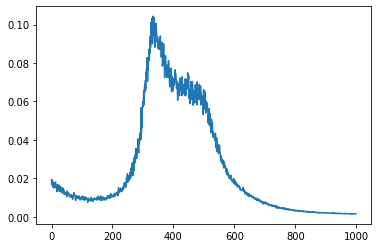

In [13]:
plt.plot((jnp.array(loss_list)))

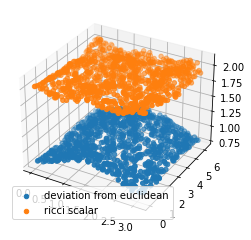

In [14]:
# 3d plot of metric
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], jnp.sum((jax.vmap(metric, in_axes=[0, None])(data, model) - jnp.diag(jnp.array([1., 1])))**2, axis=[1, 2]).reshape(-1, 1), label='deviation from euclidean')
ax.scatter(data[:, 0], data[:, 1], jax.vmap(ricci_scalar, in_axes=[0, None])(data, model), label='ricci scalar')
plt.legend()
plt.show()

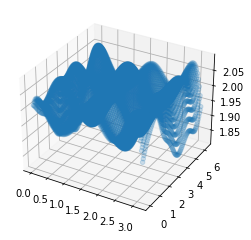

In [26]:
# 3d plot of ricci scaler
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
grid = jnp.meshgrid(jnp.linspace(0, jnp.pi, 100), jnp.linspace(0, 2*jnp.pi, 100))
grid_data = jnp.stack([grid[0].reshape(-1), grid[1].reshape(-1)], axis=1)
ax.scatter(grid_data[:, 0], grid_data[:, 1], (jax.vmap(ricci_scalar, in_axes=[0, None])(grid_data, model).reshape(-1, 1)), alpha=0.2)
plt.show()

In [16]:
g00 = jax.vmap(jnp.diag, in_axes=0)(jax.vmap(metric, in_axes=[0, None])(grid_data, model))[:, 0]
g11 = jax.vmap(jnp.diag, in_axes=0)(jax.vmap(metric, in_axes=[0, None])(grid_data, model))[:, 1]

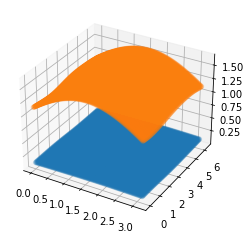

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grid_data[:, 0], grid_data[:, 1], g00, alpha=0.2)
ax.scatter(grid_data[:, 0], grid_data[:, 1], g11, alpha=0.2)
plt.show()

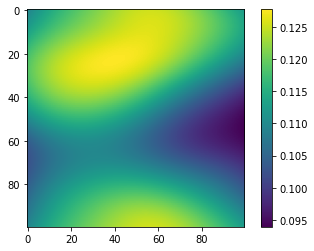

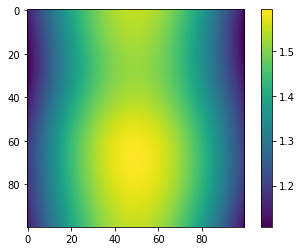

In [36]:
plt.imshow(g00.reshape(100, 100))
plt.colorbar()
plt.show()
plt.imshow(g11.reshape(100, 100))
plt.colorbar()
plt.show()